In [3]:
import sys

if sys.platform == "win32":
    file_path = "C:\\videos\\TheGreat_2_2001_169_2398_ProRes422HQ_ENG20_ENG51_BPO20_BPO51_Primary_A17913780.mov"
elif sys.platform == "linux":
    file_path = "/mnt/videos/6230046.mxf"
else:
    file_path = "/Users/leandro.correia/Documents/videos/TheGreat_2_2001_169_2398_ProRes422HQ_ENG20_ENG51_BPO20_BPO51_Primary_A17913780.mov"

print(f"File path is set to: {file_path} platform: {sys.platform}")

File path is set to: /mnt/videos/6230046.mxf platform: linux


## Using mediainfo to load media technical information

In [4]:
from pymediainfo import MediaInfo
import numpy as np

# Extract media information
media_info = MediaInfo.parse(file_path)

# Initialize variables to store audio track count and metadata
audio_tracks = []
audio_metadata = []

# Iterate through tracks to find audio tracks
for track in media_info.tracks:
    if track.track_type == "Audio":
        audio_tracks.append(track)
        audio_metadata.append(track.to_data())

# Output the number of audio tracks and their metadata
print(f"Number of audio tracks: {len(audio_tracks)}")
print("Audio track metadata:")
for idx, metadata in enumerate(audio_metadata, start=1):
    print(f"Track {idx}: {metadata}")

Number of audio tracks: 16
Audio track metadata:
Track 1: {'track_type': 'Audio', 'count': '288', 'count_of_stream_of_this_kind': '16', 'kind_of_stream': 'Audio', 'other_kind_of_stream': ['Audio'], 'stream_identifier': 0, 'other_stream_identifier': ['1'], 'streamorder': '1', 'track_id': 3, 'other_track_id': ['3'], 'format': 'PCM', 'other_format': ['PCM'], 'commercial_name': 'PCM', 'format_settings': 'Little', 'format_settings__endianness': 'Little', 'format_settings__wrapping_mode': 'Frame (AES)', 'codec_id': '0D01030102060300', 'duration': 691558, 'other_duration': ['11 min 31 s', '11 min 31 s 558 ms', '11 min 31 s', '00:11:31.558', '00:11:31.558'], 'bit_rate_mode': 'CBR', 'other_bit_rate_mode': ['Constant'], 'bit_rate': 1152000, 'other_bit_rate': ['1 152 kb/s'], 'channel_s': 1, 'other_channel_s': ['1 channel'], 'samples_per_frame': '1601.6', 'sampling_rate': 48000, 'other_sampling_rate': ['48.0 kHz'], 'samples_count': '33194784', 'frame_rate': '29.970', 'other_frame_rate': ['29.970 F

## The mediainfo audio structure

In [5]:
for key, value in audio_metadata[0].items():
    print(f"{key}: {value}")

track_type: Audio
count: 288
count_of_stream_of_this_kind: 16
kind_of_stream: Audio
other_kind_of_stream: ['Audio']
stream_identifier: 0
other_stream_identifier: ['1']
streamorder: 1
track_id: 3
other_track_id: ['3']
format: PCM
other_format: ['PCM']
commercial_name: PCM
format_settings: Little
format_settings__endianness: Little
format_settings__wrapping_mode: Frame (AES)
codec_id: 0D01030102060300
duration: 691558
other_duration: ['11 min 31 s', '11 min 31 s 558 ms', '11 min 31 s', '00:11:31.558', '00:11:31.558']
bit_rate_mode: CBR
other_bit_rate_mode: ['Constant']
bit_rate: 1152000
other_bit_rate: ['1 152 kb/s']
channel_s: 1
other_channel_s: ['1 channel']
samples_per_frame: 1601.6
sampling_rate: 48000
other_sampling_rate: ['48.0 kHz']
samples_count: 33194784
frame_rate: 29.970
other_frame_rate: ['29.970 FPS (1601.6 SPF)']
frame_count: 20726
bit_depth: 24
other_bit_depth: ['24 bits']
delay: 0
other_delay: ['00:00:00.000', '00:00:00.000']
delay_dropframe: Yes
delay__origin: Container


## Important properties to check the quality of data importer

In [6]:
audio_metadata[0].get("format")  # PCM
audio_metadata[0].get("format_settings__endianness")  # Little
audio_metadata[0].get("format_settings__wrapping_mode")  # Frame (AES)
audio_metadata[0].get("codec_id")  # 0D01030102060300
audio_metadata[0].get("duration")  # 691558
audio_metadata[0].get("bit_rate_mode")  # CBR
audio_metadata[0].get("bit_rate")  # 1152000
audio_metadata[0].get("samples_per_frame")  # 1601.6
audio_metadata[0].get("sampling_rate")  # 48000
audio_metadata[0].get("samples_count")  # 33194784
audio_metadata[0].get("frame_rate")  # 29.970
audio_metadata[0].get("frame_count")  # 20726
audio_metadata[0].get("bit_depth")  # 24
audio_metadata[0].get("delay_dropframe")  # Yes
audio_metadata[0].get("stream_size")  # 99584352
audio_metadata[0].get("blockalignment")  # 3

'3'

## Extract audio track

#### using memory extract data from video and open raw data into byte array

In [9]:
import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))

from extractor.audio_ffmpeg import AudioFFmpegExtractor

sr = 16000

ffmpeg_extractor = AudioFFmpegExtractor()

buffer = ffmpeg_extractor.extract(file_path, [0], sr)

In [10]:
type(buffer), type(buffer[0])

(bytes, int)

## get item array size

In [11]:
dtype = type(buffer[0])
sample_size_bytes = np.dtype(dtype).itemsize
sample_size_bits = sample_size_bytes * 8
print(dtype, "sample size in bytes:", sample_size_bytes, "bits:", sample_size_bits)

<class 'int'> sample size in bytes: 8 bits: 64


In [13]:
def check_bitrate(sr, bits, ch, ms):
    bit_rate = sr * bits * ch
    return bit_rate / 1000


def check_duration(raw_data, sr):
    duration_seconds = len(raw_data) / sr
    minutes = int(duration_seconds // 60)
    seconds = int(duration_seconds % 60)
    return f"{minutes}:{seconds:02d}"


total_duration = audio_metadata[0].get("duration")
print("Total duration in seconds:", total_duration / 1000)

print("Bitrate in kbps:", check_bitrate(sr, sample_size_bits, 1, total_duration))
print("Duration in millis:", check_duration(buffer, sr))

Total duration in seconds: 691.558
Bitrate in kbps: 1024.0
Duration in millis: 23:03


In [15]:
norm_flat_buffer = np.frombuffer(buffer, dtype=np.int16).astype(np.float32) / 32768.0

## Load data into librosa to draw mel spectogram

In [16]:
import numpy as np
import librosa

import librosa.display
import matplotlib.pyplot as plt

# Generate a mel spectrogram
S = librosa.feature.melspectrogram(y=norm_flat_buffer, sr=sr, n_mels=128, fmax=sr // 2)

# Convert to log scale (dB)
S_dB = librosa.power_to_db(S, ref=np.max)

## using matplotlib to draw

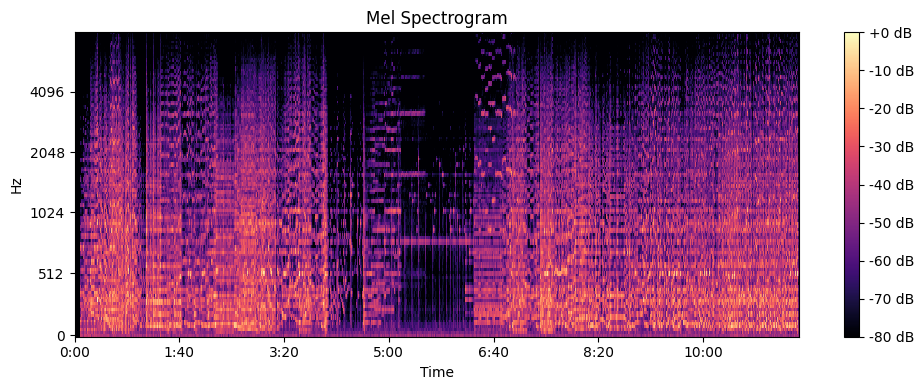

In [17]:
# Plot the mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis="time", y_axis="mel", fmax=sr // 2)
plt.colorbar(format="%+2.0f dB")
plt.title("Mel Spectrogram")
plt.tight_layout()
plt.show()

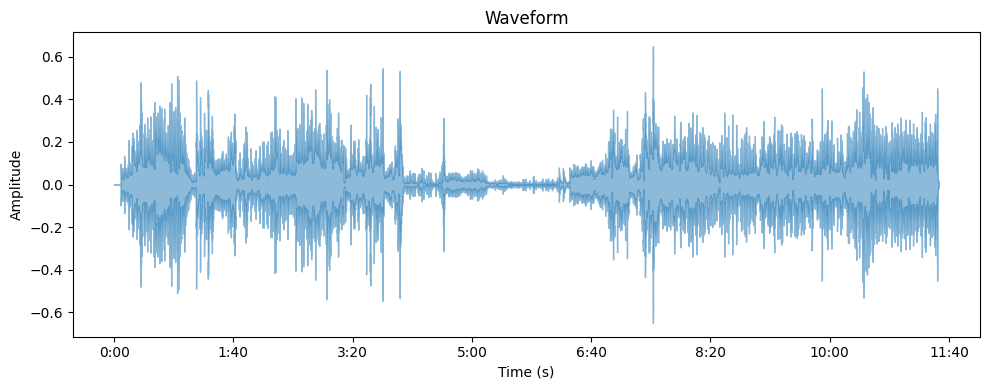

In [18]:
import librosa.display

# Plot the waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(norm_flat_buffer, sr=sr, alpha=0.5)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

In [19]:
def draw_waveforms(data_list, sr):
    """
    Draw a list of waveforms in a pyplot subplot format.

    Args:
        data_list (list of np.ndarray): List of audio data arrays.
        sr (int): Sampling rate of the audio data.
    """
    num_waveforms = len(data_list)
    rows = (num_waveforms + 1) // 2  # Two waveforms per row

    plt.figure(figsize=(12, rows * 3))

    for idx, data in enumerate(data_list):
        plt.subplot(rows, 2, idx + 1)
        librosa.display.waveshow(data.get("data"), sr=sr, alpha=0.5)
        plt.title("Waveform {} layout {}".format(idx, data.get("channel_layout")))
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")

    plt.tight_layout()
    plt.show()

## Drawing and expose silent tracks

In [52]:
# 10912567_300frames.mxf
# 11785979_300frames.mxf
# 11812228_300frames.mxf
# 11819010_300frames.mxf
# 11825285_300frames.mxf
# 6441861_300frames.mxf

file_path = "/mnt/videos/multiple-audio-tracks/6441861_300frames.mxf"

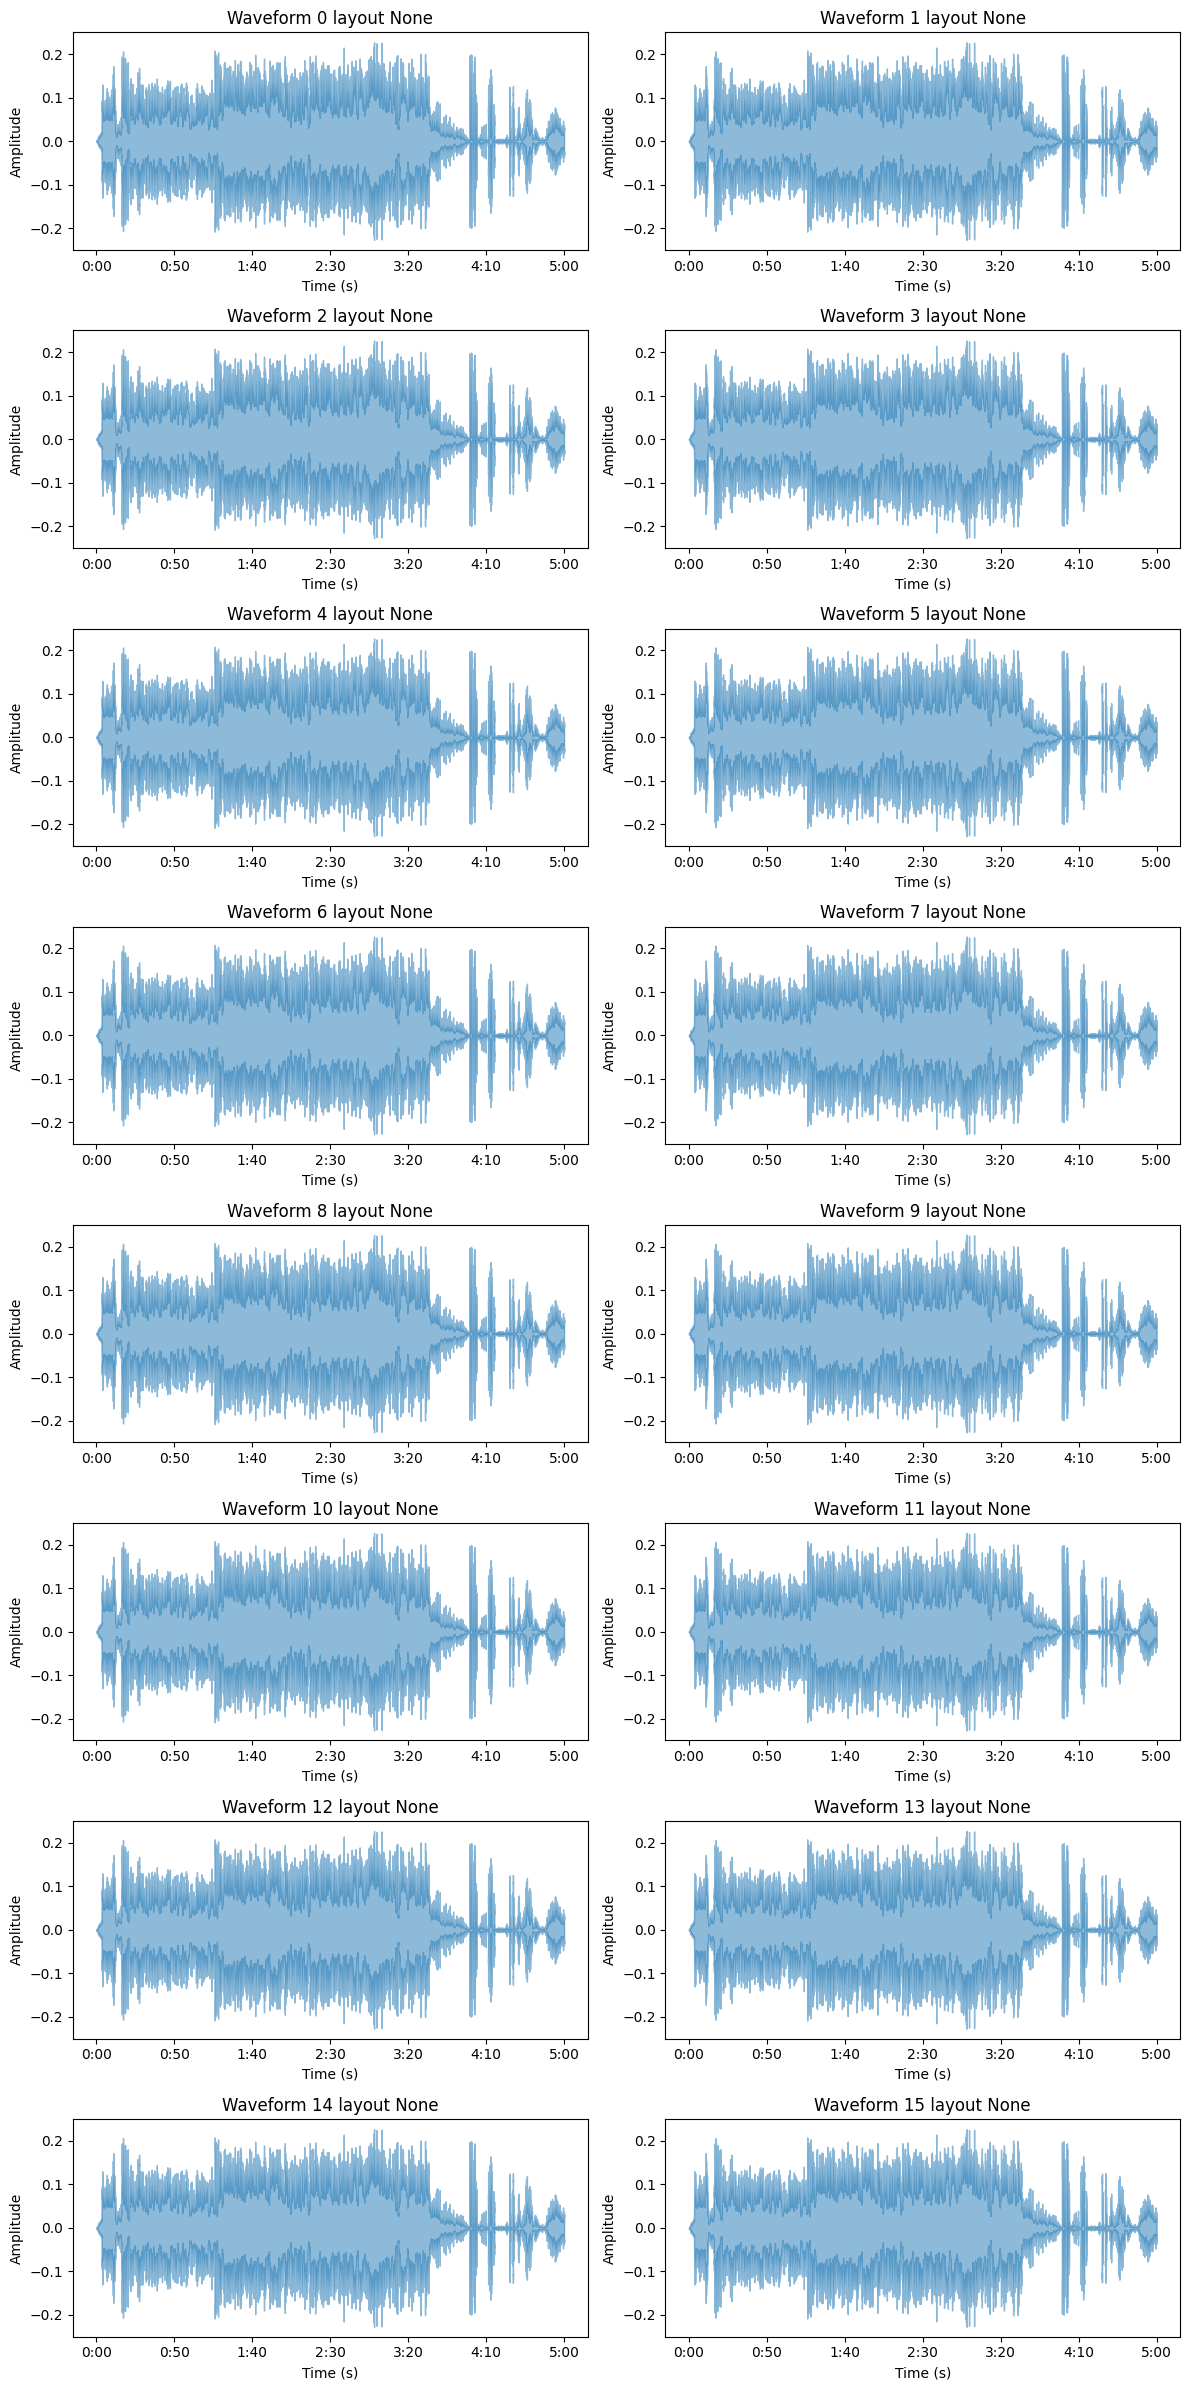

In [53]:
import sys
import os
import numpy as np

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))

from extractor.audio_ffmpeg import AudioFFmpegExtractor
from pymediainfo import MediaInfo


SAMPLING_RATE = 16000

# Extract media information
media_info = MediaInfo.parse(file_path)

# Initialize variables to store audio track count and metadata
audio_tracks = []

ffmpeg_extractor = AudioFFmpegExtractor()
# Iterate through tracks to find audio tracks
for track in media_info.tracks:
    if track.track_type == "Audio":
        buffer = ffmpeg_extractor.extract(
            file_path, [track.to_data().get("stream_identifier")], SAMPLING_RATE
        )

        norm_flat_buffer = (
            np.frombuffer(buffer, dtype=np.int16).astype(np.float32) / 32768.0
        )
        audio_tracks.append(
            {
                "id": track.to_data().get("stream_identifier"),
                "data": norm_flat_buffer,
                "channel_layout": track.to_data().get("channel_layout"),
            }
        )


draw_waveforms(audio_tracks, SAMPLING_RATE)

## Compare stereo against 5.1

In [ ]:
for audio in audio_tracks:
    print(audio.get("id"), audio.get("channel_layout"))

## Compare channels using correlation
Check if L and Lt (and R and Rt) are highly correlated (≈1.0)

If correlation > 0.99, they’re probably duplicates or matrixed from the same source.

In [ ]:
import numpy as np
from scipy.stats import pearsonr


get_track_by_layout = lambda layout: next(
    track for track in audio_tracks if track.get("channel_layout") == layout
)

lt = get_track_by_layout("Lt").get("data")
rt = get_track_by_layout("Rt").get("data")
l = get_track_by_layout("L").get("data")
r = get_track_by_layout("R").get("data")

corr_l, _ = pearsonr(lt, l)  # Compare Lt vs L
corr_r, _ = pearsonr(rt, r)  # Compare Rt vs R

print(f"Correlation Lt vs L: {corr_l:.3f}")
print(f"Correlation Rt vs R: {corr_r:.3f}")

# Comparing Left Total with Right Total

In [ ]:
corr_lt_rt, _ = pearsonr(lt, rt)
print(f"Correlation Lt vs Rt: {corr_lt_rt:.3f}")

corr_l_r, _ = pearsonr(l, r)
print(f"Correlation left vs right: {corr_l_r:.3f}")

## Checking low effects frequency

If the plot shows most energy < 120 Hz, then it's a proper LFE.

In [ ]:
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq

# lfe: numpy array of LFE channel
sample_rate = 44100  # or your actual rate

lfe = get_track_by_layout("LFE").get("data")

N = len(lfe)
yf = rfft(lfe)
xf = rfftfreq(N, 1 / sample_rate)

plt.plot(xf, np.abs(yf))
plt.xlim(0, 500)  # Focus on bass range
plt.title("LFE Frequency Content")
plt.xlabel("Hz")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

In [ ]:
from scipy.signal import butter, filtfilt


def lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    return filtfilt(b, a, data)


filtered_lfe = lowpass_filter(lfe, 120, sample_rate)
plt.plot(xf, np.abs(rfft(filtered_lfe)))
plt.xlim(0, 500)  # Focus on bass range

In [ ]:
ls = get_track_by_layout("Ls").get("data")
rs = get_track_by_layout("Rs").get("data")

corr_ls_l, _ = pearsonr(ls, l)
corr_rs_r, _ = pearsonr(rs, r)

print(f"Correlation Ls vs L: {corr_ls_l:.3f}")
print(f"Correlation Rs vs R: {corr_rs_r:.3f}")

In [ ]:
import librosa
import librosa.display

c = get_track_by_layout("C").get("data")


signals = [l, r, c, lfe, ls, rs]
labels = ["L", "R", "C", "LFE", "Ls", "Rs"]

n = len(signals)
cols = 2
rows = (n + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
axes = axes.flatten()

for i, (signal, label) in enumerate(zip(signals, labels)):
    D = librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max)
    img = librosa.display.specshow(
        D, sr=sample_rate, x_axis="time", y_axis="log", ax=axes[i]
    )
    axes[i].set_title(f"Spectrogram: {label}")
    fig.colorbar(img, ax=axes[i], format="%+2.0f dB")
    axes[i].label_outer()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()